# Category Prediction on BBC-news data

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns

import json, re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from helper import plot_history

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

data_dir = '../nlp_datasets/13_bbc_news_category/'

In [2]:
df = pd.read_csv(data_dir+'bbc-text.csv')
print ('data.shape:',df.shape)
df.head(2)

data.shape: (2225, 2)


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...


In [3]:
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

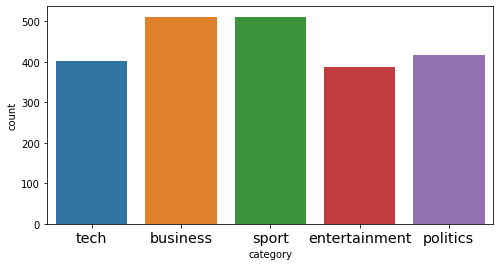

In [45]:
fig, ax = plt.subplots(1,1,figsize=(8,4));
sns.countplot(df['category'], ax=ax);
plt.xticks(fontsize='x-large');

## Label Encoding

- convert the labels to numerical labels
- can use sklearn.preprocessing import LabelEncoder()
- but here implement your own. it's simple


In [5]:
label_dict = {df.category.unique()[i]:i for i in range(len(df.category.unique()))}
label_dict

{'tech': 0, 'business': 1, 'sport': 2, 'entertainment': 3, 'politics': 4}

In [6]:
df['label'] = df['category'].apply(lambda x:label_dict[x])
df.head(5)

,category,text,label
0,tech,tv future in the hands of viewers with home th...,0
1,business,worldcom boss left books alone former worldc...,1
2,sport,tigers wary of farrell gamble leicester say ...,2
3,sport,yeading face newcastle in fa cup premiership s...,2
4,entertainment,ocean s twelve raids box office ocean s twelve...,3


In [7]:
import nltk, re
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
st=PorterStemmer()

def process_text(text):
    text = text.lower()
    
    text = re.sub(r'[/(){}\[\]\|@,;]', '', text)
    text = re.sub(r'[^0-9a-z #+_]', '', text)
    text = re.sub(r'https?://\S+', ' ', text)
    text = re.sub(r'[0-9+]', '', text)
    #remove stopwords and stemmize
    text=" ".join(st.stem(w) for w in text.split() if w not in STOPWORDS)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gshyam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
print ( "original text:", df.text[12][:100])
print ("processed text:", process_text(df.text[12][:100])) 

original text: crude oil prices back above $50 cold weather across parts of the united states and much of europe ha
processed text: crude oil price back cold weather across part unit state much europ ha


In [9]:
df['text_processed'] = df['text']#.apply(process_text)
df['text_len'] = df['text_processed'].apply(lambda x: len(x.split()))

df.head(4)

,category,text,label,text_processed,text_len
0,tech,tv future in the hands of viewers with home th...,0,tv future in the hands of viewers with home th...,737
1,business,worldcom boss left books alone former worldc...,1,worldcom boss left books alone former worldc...,300
2,sport,tigers wary of farrell gamble leicester say ...,2,tigers wary of farrell gamble leicester say ...,246
3,sport,yeading face newcastle in fa cup premiership s...,2,yeading face newcastle in fa cup premiership s...,341


## Prepare input for Model
- train, test, val split
- tokenize the text
- Pad the Sequences to a certain length
- convert the y labels to categorical

In [10]:
def split_data(data):
    X_train_, X_test, y_train_, y_test = train_test_split(data['text_processed'].values, data['label'].values, test_size=0.2)
    X_train,  X_val, y_train, y_val = train_test_split(X_train_, y_train_, test_size=0.25)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)

In [11]:
df.text_len.max()

4492

In [12]:
MAX_SEQ_LEN = 2000 # length of each text
MAX_WORDS   = 1000 # use only this many max used words

def prepare_data_for_model(X_train, X_val, X_test,
                               y_train, y_val, y_test, 
                               text_to_matrix=False):
    
    tokenizer = Tokenizer(num_words=MAX_WORDS)
    tokenizer.fit_on_texts(X_train)

    if text_to_matrix:
        X_train = tokenizer.texts_to_matrix(X_train)
        X_val   = tokenizer.texts_to_matrix(X_val)    
        X_test  = tokenizer.texts_to_matrix(X_test)
    else:
        X_train = tokenizer.texts_to_sequences(X_train)
        X_val   = tokenizer.texts_to_sequences(X_val)    
        X_test  = tokenizer.texts_to_sequences(X_test)

        X_train = pad_sequences(X_train, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
        X_val   = pad_sequences(X_val,   maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
        X_test  = pad_sequences(X_test,  maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
    
    y_train = to_categorical(y_train)
    y_val   = to_categorical(y_val)
    y_test  = to_categorical(y_test)

    print (f"X_train.shape: {X_train.shape} y_train.shape:{y_train.shape}" )
    print (f"X_test.shape: {X_test.shape} y_test.shape:{y_test.shape}" )
    print (f"X_val.shape: {X_val.shape} y_val.shape:{y_val.shape}" )
    
    return (X_train, X_val, X_test, y_train, y_val, y_test, tokenizer)

# Model: Dense Layers only

In [13]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization
from keras.layers.embeddings import Embedding

In [14]:
(X_train, X_val, X_test,
 y_train, y_val, y_test,
 tokenizer) = prepare_data_for_model(X_train, X_val, X_test,
                                     y_train, y_val, y_test,
                                     text_to_matrix=True)

X_train.shape: (1335, 1000) y_train.shape:(1335, 5)
X_test.shape: (445, 1000) y_test.shape:(445, 5)
X_val.shape: (445, 1000) y_val.shape:(445, 5)


In [18]:
def make_model(X, y):
    model = Sequential()
    model.add(Dense(16, input_shape=(X.shape[1],), activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(y.shape[1], activation='softmax'))
    opt = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model1 = make_model(X_train, y_train)
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                16016     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 85        
Total params: 16,101
Trainable params: 16,101
Non-trainable params: 0
_________________________________________________________________


In [19]:
history1 = model1.fit(X_train, y_train,
                      validation_data=(X_val, y_val), 
                      epochs=5, batch_size=32, verbose=1)

Epoch 1/5
42/42 [==============================] - 0s 4ms/step - loss: 1.2813 - accuracy: 0.5723 - val_loss: 0.8686 - val_accuracy: 0.8112
Epoch 2/5
42/42 [==============================] - 0s 2ms/step - loss: 0.5751 - accuracy: 0.9206 - val_loss: 0.4226 - val_accuracy: 0.9213
Epoch 3/5
42/42 [==============================] - 0s 2ms/step - loss: 0.2810 - accuracy: 0.9678 - val_loss: 0.2774 - val_accuracy: 0.9438
Epoch 4/5
42/42 [==============================] - 0s 2ms/step - loss: 0.1716 - accuracy: 0.9835 - val_loss: 0.2163 - val_accuracy: 0.9528
Epoch 5/5
42/42 [==============================] - 0s 1ms/step - loss: 0.1154 - accuracy: 0.9910 - val_loss: 0.1851 - val_accuracy: 0.9528


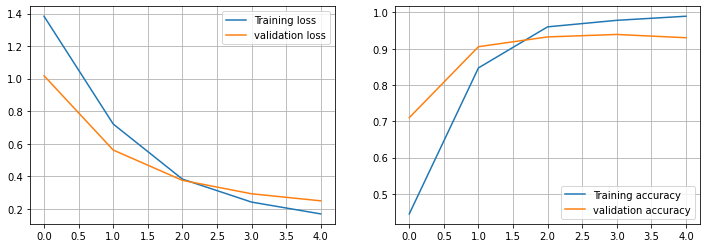

In [17]:
plot_history(history1)

# Model: LSTM+Dense

In [ ]:
(X_train, X_val, X_test,
 y_train, y_val, y_test,
 tokenizer) = prepare_data_for_model(X_train, X_val, X_test,
                                     y_train, y_val, y_test,
                                     text_to_matrix=False)

In [ ]:
def make_model(X, y, embedding_length = 16):
    model = Sequential()
    model.add(Embedding(MAX_WORDS, embedding_length, input_length=X.shape[1]))
    model.add(LSTM(16, activation='relu'))#, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model2 = make_model(X_train, y_train)
model2.summary()

In [ ]:
history2 = model2.fit(X_train, y_train,
                    validation_data=(X_val, y_val), 
                    epochs=5,
                    batch_size=16,
                    verbose=1)

In [ ]:
plot_history(history2)

Not extirely sure why LSTM performs so poorly for this dataset (only 20% validation accuracy). I should understand LSTM better, I guess.

Anyway, let's continue with model1 for prediction on test data.

## Prediction

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [21]:
y_pred = model1.predict(X_test)

In [22]:
from sklearn.metrics import confusion_matrix

In [25]:
y_test_ = np.argmax(y_test,axis=1)
y_pred_ = np.argmax(y_pred,axis=1)
print ("test set size:", y_test_.shape, y_pred_.shape)
print ( y_test_[:10], y_pred_[:10] )

test set size: (445,) (445,)
[2 2 4 0 3 0 3 2 2 3] [2 2 4 0 3 0 3 2 2 3]


[[ 67   0   1   1   1]
 [  2  98   0   0   2]
 [  0   0 105   2   1]
 [  1   1   1  85   1]
 [  1   2   0   1  72]]


<AxesSubplot:>

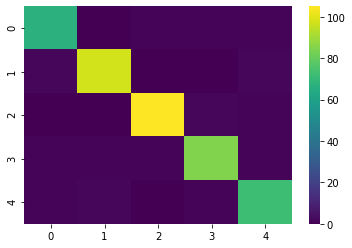

In [26]:
confusionmatrix=confusion_matrix( y_test_, y_pred_)
print (confusionmatrix)
sns.heatmap(confusionmatrix, cmap='viridis')

In [27]:
acc_test=accuracy_score(y_test_, y_pred_)
f1_macro=f1_score(y_test_, y_pred_, average='macro')
print ("Test set accuracy score: %1.2f" % (100*acc_test))
print ("Test set f1 score: %1.2f " % (100*f1_macro))

Test set accuracy score: 95.96
Test set f1 score: 95.78 


## Save the Model, tokenizer and configs

In [28]:
import pickle
import json

model1.save('model_dense')

with open('tokenizer.pkl', 'wb') as fp:
    pickle.dump(tokenizer, fp)

with open('label_dict.json', 'w') as fp:
    json.dump(label_dict, fp, indent = 4)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_dense/assets


## Load the saved Model, tokenizer and configs

In [29]:
# loading the saved model, vocab, filtered_words
from tensorflow.keras.models import load_model
model = load_model('./model_dense')

with open('tokenizer.pkl', 'rb') as fp:
    tokenizer=pickle.load(fp) 
    
with open('label_dict.json', 'r') as fp:
    label_dict=json.load(fp)

print ("Model Loaded.")

Model Loaded.


## Predictions

In [40]:
def Prediction(doc, model=model, tokenizer=tokenizer, label_dict=label_dict):
    doc_processed = process_text(doc)
    X_in = tokenizer.texts_to_matrix([doc_processed])
    y_out = model.predict(X_in)
    category_indx = np.argmax(y_out,axis=1)[0]
    category = [i for i in list(label_dict.keys()) if label_dict[i]==category_indx][0]
    print (f"The following text\n\n {doc} \n\n\
    is categorized as \n\n {category}")

In [41]:
# some current news from bbc news website
doc="Mr Trump responded on Tuesday with his lengthiest statement since he left office a month ago. The Republican Party can never again be respected or strong with political 'leaders' like Senator Mitch McConnell at its helm, the press release reads.\
Mr McConnell's lack of political insight, wisdom, skill, and personality had cost the Republicans control of the Senate following last November's elections, he said.\
The former president said the Republican leader begged for his endorsement in his own Senate race, without which Mr Trump claimed Mr McConnell would have lost.\
Mr Trump took aim at Mr McConnell's stated intentions to stand in the way of future Trump-backed candidates.\
The former president said he would back Republican primary challengers who espouse Making America Great Again and our policy of America First.\
Mr McConnell will never do what needs to be done, or what is right for our Country, said Mr Trump.\
We know our America First agenda is a winner, not McConnell's Beltway First agenda or Biden's America Last."

In [42]:
Prediction(doc)

The following text

 Mr Trump responded on Tuesday with his lengthiest statement since he left office a month ago. The Republican Party can never again be respected or strong with political 'leaders' like Senator Mitch McConnell at its helm, the press release reads.Mr McConnell's lack of political insight, wisdom, skill, and personality had cost the Republicans control of the Senate following last November's elections, he said.The former president said the Republican leader begged for his endorsement in his own Senate race, without which Mr Trump claimed Mr McConnell would have lost.Mr Trump took aim at Mr McConnell's stated intentions to stand in the way of future Trump-backed candidates.The former president said he would back Republican primary challengers who espouse Making America Great Again and our policy of America First.Mr McConnell will never do what needs to be done, or what is right for our Country, said Mr Trump.We know our America First agenda is a winner, not McConnell's 

In [43]:
doc="England were bowled out for 134 and 164, losing all 10 second-innings wickets to spin as India levelled the four-match series at 1-1.\
A dry pitch was heavily criticised for offering extravagant spin throughout.\Conditions were challenging for both sides but we showed more application, grit and determination to battle it out, Kohli said.\We didn't panic looking at the amount of turn and bounce on that pitch.\
We trusted our defence, got into the game and scored 600 in two innings combined."

In [44]:
Prediction(doc)

The following text

 England were bowled out for 134 and 164, losing all 10 second-innings wickets to spin as India levelled the four-match series at 1-1.A dry pitch was heavily criticised for offering extravagant spin throughout.\Conditions were challenging for both sides but we showed more application, grit and determination to battle it out, Kohli said.\We didn't panic looking at the amount of turn and bounce on that pitch.We trusted our defence, got into the game and scored 600 in two innings combined. 

    is categorized as 

 sport
